In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Preparation 

In [10]:
# Loading the training and testing dataset

training = pd.read_csv('UNSW_NB15_training-set.csv')
testing = pd.read_csv('UNSW_NB15_testing-set.csv')
print("training ",training.shape)
print("testing ",testing.shape)

training  (82332, 45)
testing  (175341, 45)


In [11]:
# Identifying if columns in both training and testing dataset match so the I can merge them 

all(training.columns == testing.columns)

True

In [15]:
df = pd.concat([training,testing]).drop('id',axis=1)
df = df.reset_index(drop=True)

df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  di

In [80]:
# Check for null values in each column
null_counts = df.isnull().sum()

# Display null counts for each column
print(null_counts)

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
label      

In [53]:
# Identifying number of unique attacks 
df.attack_cat.unique()

['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic']
Categories (10, object): ['Analysis', 'Backdoor', 'DoS', 'Exploits', ..., 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']

In [19]:
# Converting object variable into numerical variable 
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes
    
df['attack_cat'] = df['attack_cat'].astype('category')

# Visualising attack catagories

Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Normal                0
Name: attack_cat, dtype: int64


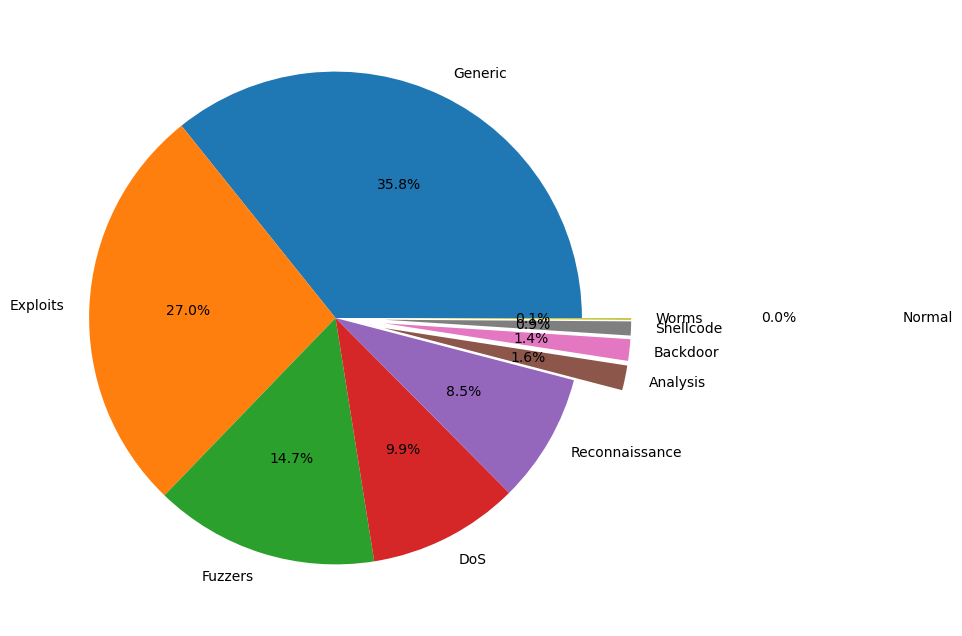

In [81]:
## Selecting rows from the dataframe where 'label' equals 1 and counting occurrences of each 'attack_cat'
validAttacks = df[df['label']==1]['attack_cat'].value_counts()
print(validAttacks)

plt.figure(figsize = (15,8))
plt.pie(validAttacks,labels = validAttacks.index, autopct = '%1.1f%%',explode = [0,0,0,0,0,0.2,0.2,0.2,0.2,1.2])
plt.show()

# Splitting data 

In [54]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['attack_cat', 'label'])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

feature_names = list(X.columns)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (180371, 42)
y_train shape:  (180371,)
X_test shape:  (77302, 42)
y_test shape:  (77302,)


# Decision tree model 

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

# Define the grid of hyperparameters to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Initialize a DecisionTreeClassifier object
dtc = DecisionTreeClassifier()

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

# Get the best estimator from the grid search
dtc_best = grid_search.best_estimator_

dtc_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dtc_best.predict(X_test)

# Calculate recall score on the test data
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)



Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 0.9994463667820069
Recall:  1.0


# Visualising the rules 

RULES FOR HIGH RECALL RATE: |--- sttl <= 61.00
|   |--- sinpkt <= 0.00
|   |   |--- class: 1
|   |--- sinpkt >  0.00
|   |   |--- class: 0
|--- sttl >  61.00
|   |--- synack <= 0.04
|   |   |--- class: 1
|   |--- synack >  0.04
|   |   |--- class: 1



/Users/ishanjoshi/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


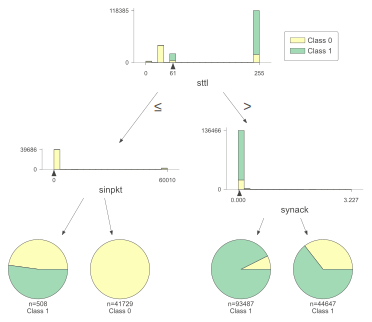

In [58]:
from sklearn.tree import export_text
import dtreeviz

print("RULES FOR HIGH RECALL RATE:", export_text(dtc_best, feature_names=feature_names))
viz_model = dtreeviz.model(dtc_best, X_train=X_train, y_train=y_train, feature_names=feature_names)  
viz_model.view()

# Prepare test data for further analysis

In [59]:
X_test = X_test.reset_index(drop=True)
rules = "(sttl <= 61.00 & sinpkt <= 0.00) | (sttl > 61.00)"

ind = X_test.query(rules).index

X_test_2 = X_test.loc[ind, :]
y_test_2 = y_test[ind]

print(X_test.shape)
print(X_test_2.shape)
print("Filtered data percentage:", (1 - np.round(X_test_2.shape[0] / X_test.shape[0], 2)) * 100, "%")


(77302, 42)
(59155, 42)
Filtered data percentage: 23.0 %


# Defining a function to evaluate various models on filtered test data 

In [27]:
from sklearn.metrics import accuracy_score, precision_score

In [62]:
# Define a function to evaluate the performance of a given model
def model_evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_2)
    
    accuracy = accuracy_score(y_test_2, y_pred)
    recall = recall_score(y_test_2, y_pred)
    precision = precision_score(y_test_2, y_pred)
    
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("Accuracy: ", accuracy)
    
    # Create a confusion matrix to compare actual and predicted classifications
    cross = pd.crosstab(pd.Series(y_test_2, name='Actual'), pd.Series(y_pred, name='Predicted'))
    
    # Visualize the confusion matrix using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cross, annot=True, fmt='d', cmap="coolwarm")
    plt.show()
    
    return {'Recall' : recall}


In [63]:
results = {}

# Train and evaluate Random Forest model

Recall:  0.959264768813808
Precision:  0.961125403242272
Accuracy:  0.9340207928323895


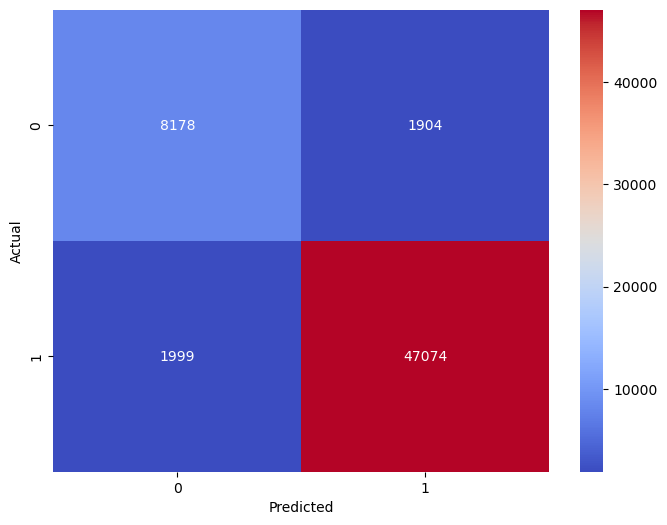

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11)

results['Random Forest Model'] = model_evaluation(rf)

# Train and evaluate XGBoost model

Recall:  0.9534978501416257
Precision:  0.9625995186076652
Accuracy:  0.9306905587017158


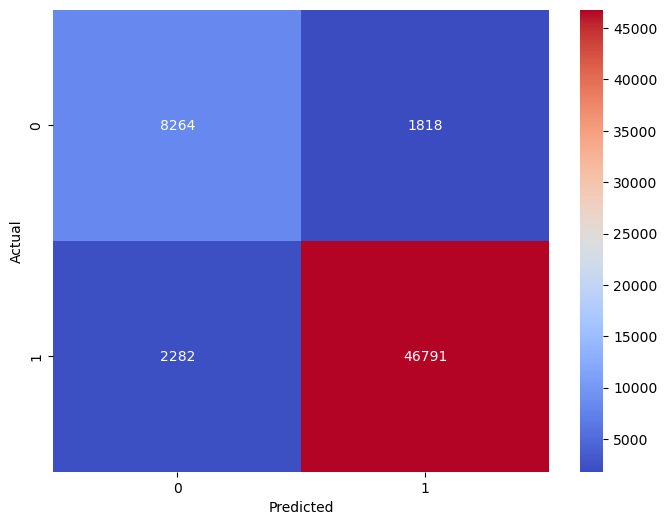

In [65]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()

results['XGBoost Classifier'] = model_evaluation(xgbc)

# Train and evaluate Light GBM model

[LightGBM] [Info] Number of positive: 115600, number of negative: 64771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6187
[LightGBM] [Info] Number of data points in the train set: 180371, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.640901 -> initscore=0.579278
[LightGBM] [Info] Start training from score 0.579278
Recall:  0.9479550873188922
Precision:  0.961652954066234
Accuracy:  0.9254669934916744


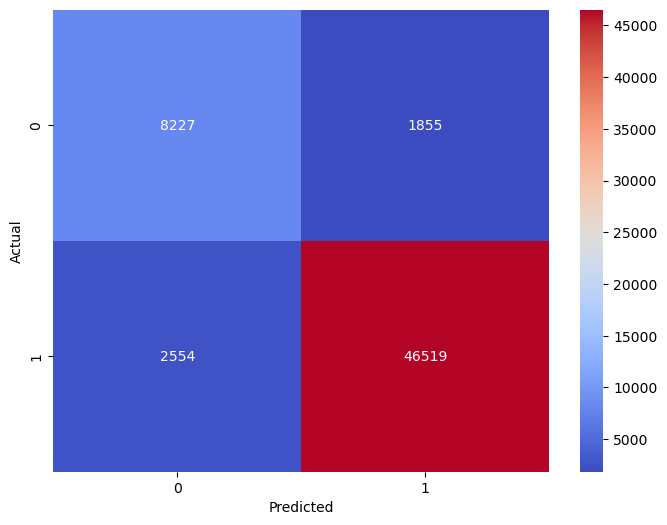

In [66]:
from lightgbm import LGBMClassifier

lgbc = LGBMClassifier()

results['Light GBM Classifier'] = model_evaluation(lgbc)

# Compare recall scores of different models using Wilcoxon test

In [67]:
comparision = pd.DataFrame(results)
comparision

,Random Forest Model,XGBoost Classifier,Light GBM Classifier
Recall,0.959265,0.953498,0.947955


In [68]:
from scipy.stats import wilcoxon

z_statistic, p_value = wilcoxon([comparision.iloc[0][0], comparision.iloc[0][1], comparision.iloc[0][2]])
print('Z-statistic:', z_statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print('The difference in the recall of the three models is statistically significant.')
else:
    print('The difference in the recall of the three models is not statistically significant.')


Z-statistic: 0.0
p-value: 0.25
The difference in the recall of the three models is not statistically significant.


# Visualize correlation between features and label

/var/folders/mn/z4_vnw492pn6914bybynqzj80000gn/T/ipykernel_13938/1926109083.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
/var/folders/mn/z4_vnw492pn6914bybynqzj80000gn/T/ipykernel_13938/1926109083.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/var/folders/mn/z4_vnw492pn6914bybynqzj80000gn/T/ipykernel_13938/1926109083.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify th

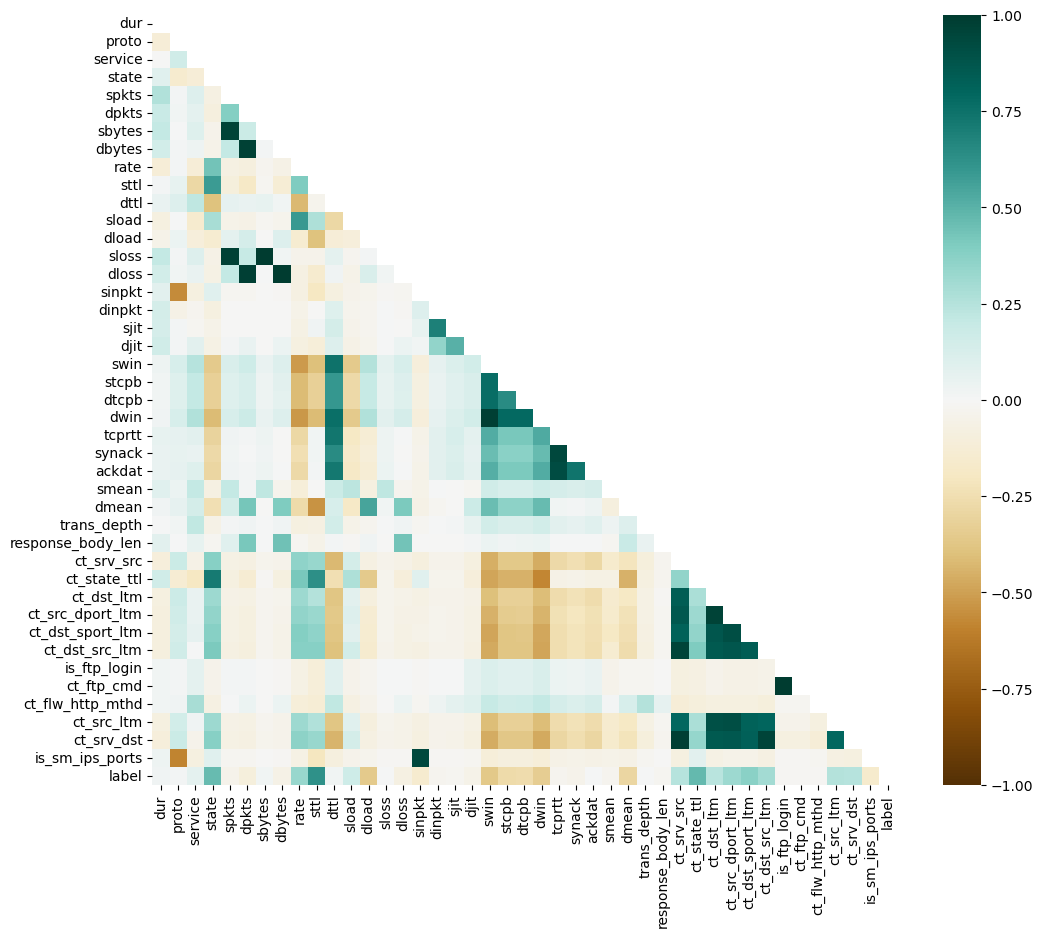

In [70]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
sns.heatmap(df.corr(),vmin=-1, vmax=1,cmap='BrBG', mask=mask)
plt.show()

/var/folders/mn/z4_vnw492pn6914bybynqzj80000gn/T/ipykernel_13938/532101476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


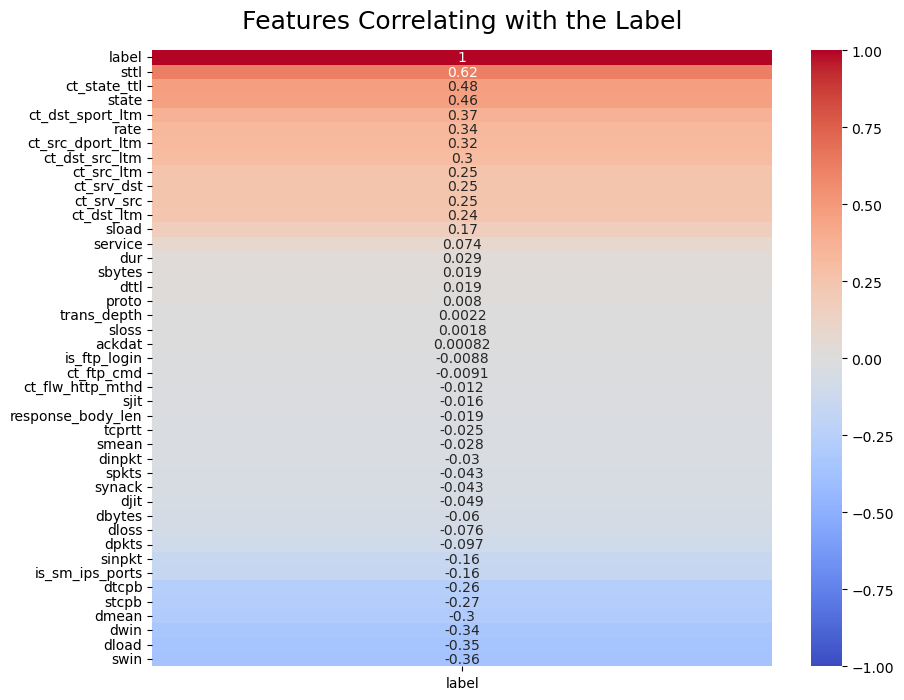

In [69]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df.corr()[['label']].sort_values(by='label', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Features Correlating with the Label', fontdict={'fontsize': 18}, pad=16)
plt.show()

# Visualize feature importances and rank features 

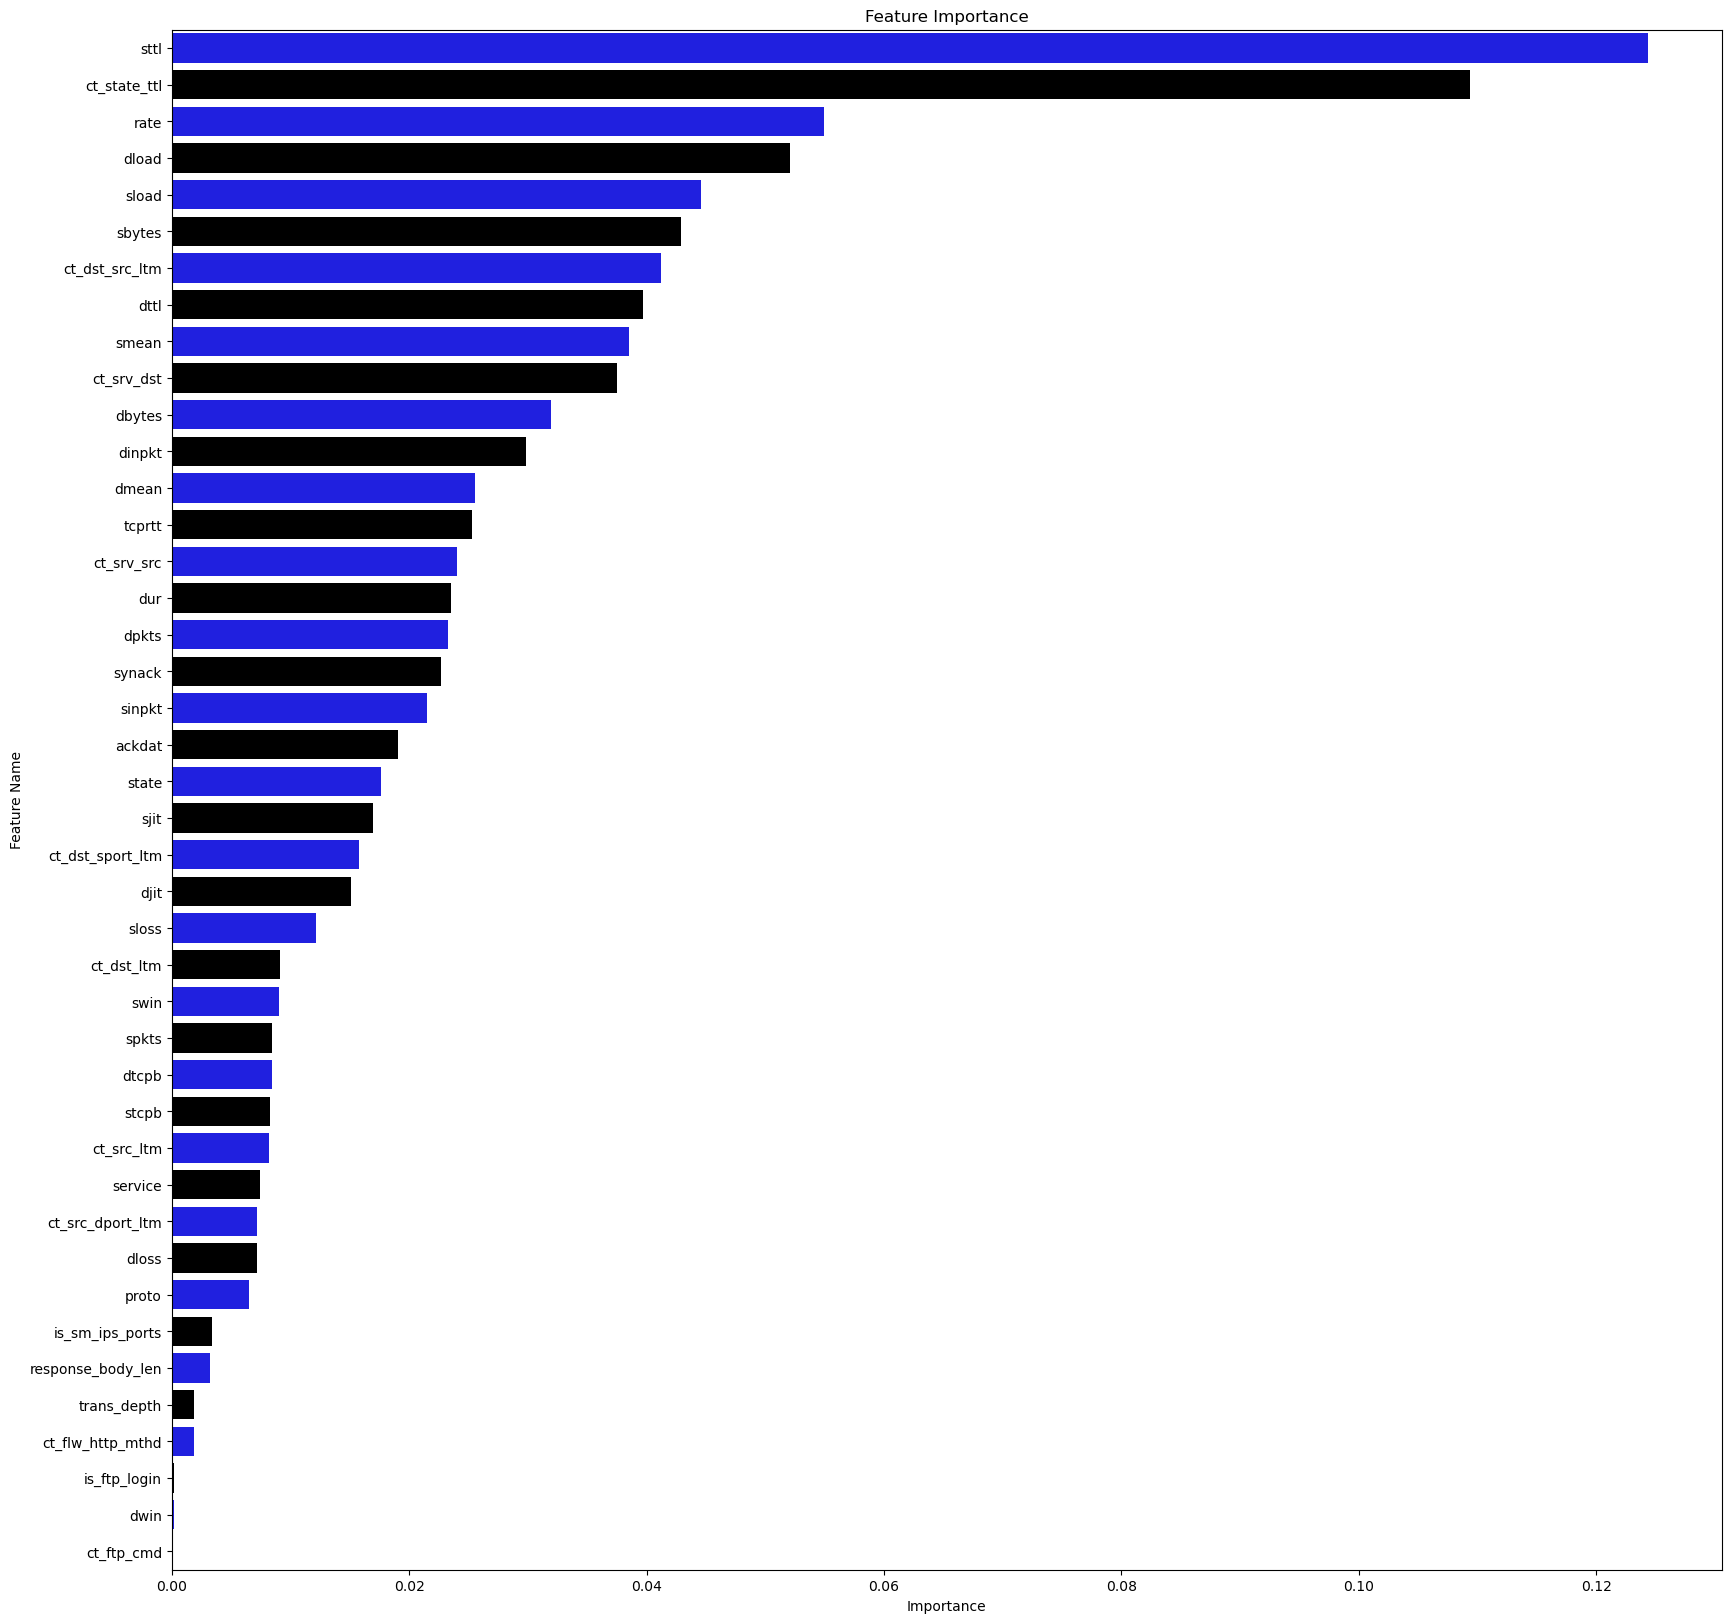

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.barplot(data=feature_imp, y='Name', x='Importance', palette=['blue', 'black'])
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()


# Selecting top 10 features 

In [79]:
feature_imp = pd.DataFrame({'Name':X.columns, 'Importance':rf.feature_importances_})

feature_imp = feature_imp.sort_values('Importance',ascending=False).reset_index(drop=True)

feature_imp[:10].style.background_gradient()

,Name,Importance
0,sttl,0.128590
1,ct_state_ttl,0.102997
2,rate,0.050694
3,dload,0.049235
4,sbytes,0.047843
5,sload,0.046914
6,ct_srv_dst,0.039795
7,ct_dst_src_ltm,0.039667
8,smean,0.039483
9,tcprtt,0.039229


In [47]:
top10= feature_imp.Name[:10].tolist()
top10

['sttl',
 'ct_state_ttl',
 'rate',
 'dload',
 'sload',
 'sbytes',
 'ct_dst_src_ltm',
 'dttl',
 'smean',
 'ct_srv_dst']

# Train and evaluate Random Forest model using top 10 features

In [48]:
X = df[top10]
y = df['label'].values

rf_top10 = RandomForestClassifier(random_state=11)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

rf_top10.fit(X_train, y_train)

y_pred = rf_top10.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)
 

Accuracy:  0.941760885876174


In [61]:
top10= feature_imp.Name[:10].tolist()

attack_names = np.array(df['attack_cat'].unique())

X_top = df.loc[:, df.columns.isin(top10)]
y_top = pd.factorize(df['attack_cat'])[0]


clf_top10 = DecisionTreeClassifier(max_depth=6)

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.3, random_state=11)

clf_top10.fit(X_train_top, y_train_top)



DecisionTreeClassifier(max_depth=6)

# Train and evaluate Random Forest model using top 10 features for attack category prediction

Accuracy:  0.822992936793356


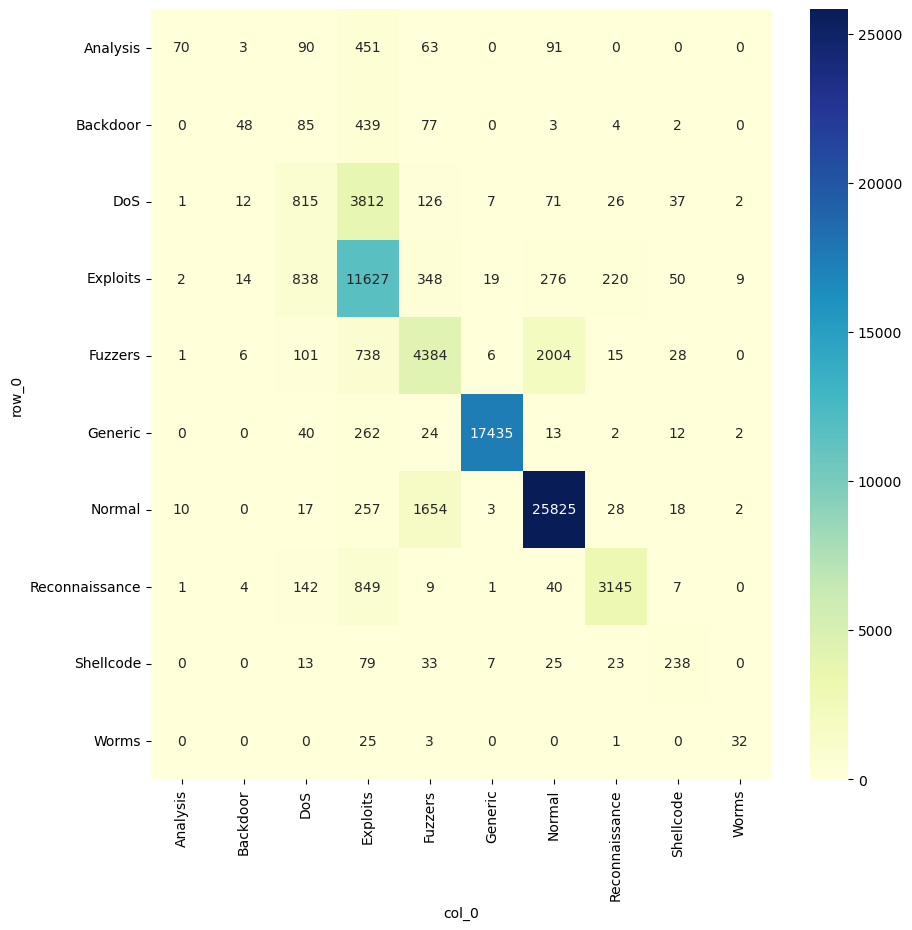

In [50]:
top10= feature_imp.Name[:10].tolist()

X = df.loc[:, df.columns.isin(top10)]

y = df['attack_cat'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

rf = RandomForestClassifier(random_state=11,min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

cross = pd.crosstab(y_test,  y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")
plt.show()

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

                precision    recall  f1-score   support

      Analysis       0.82      0.09      0.16       768
      Backdoor       0.55      0.07      0.13       658
           DoS       0.38      0.17      0.23      4909
      Exploits       0.63      0.87      0.73     13403
       Fuzzers       0.65      0.60      0.63      7283
       Generic       1.00      0.98      0.99     17790
        Normal       0.91      0.93      0.92     27814
Reconnaissance       0.91      0.75      0.82      4198
     Shellcode       0.61      0.57      0.59       418
         Worms       0.68      0.52      0.59        61

      accuracy                           0.82     77302
     macro avg       0.71      0.56      0.58     77302
  weighted avg       0.82      0.82      0.81     77302



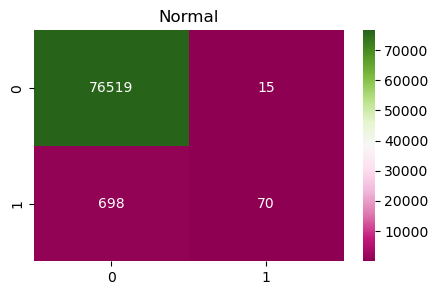

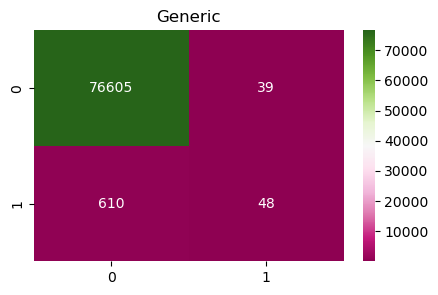

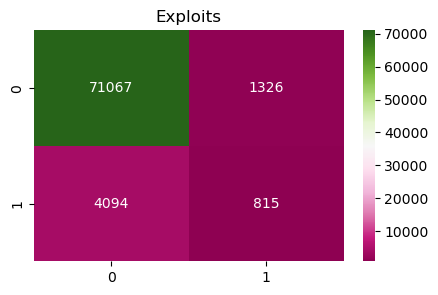

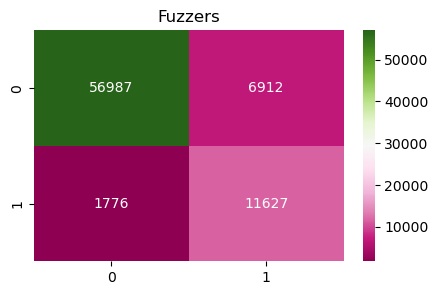

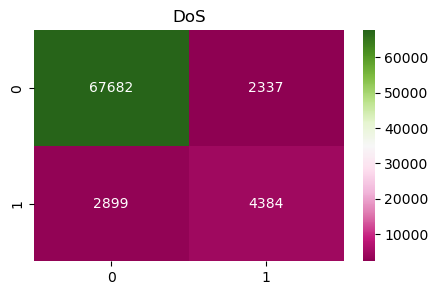

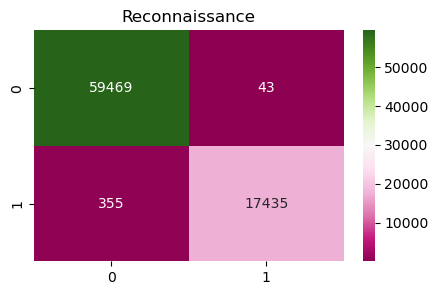

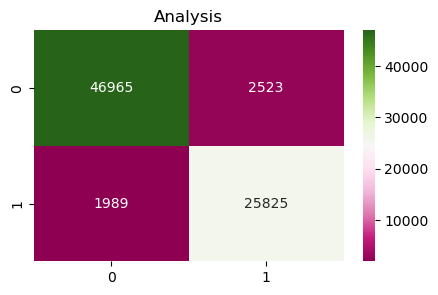

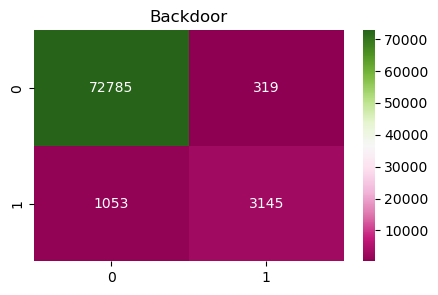

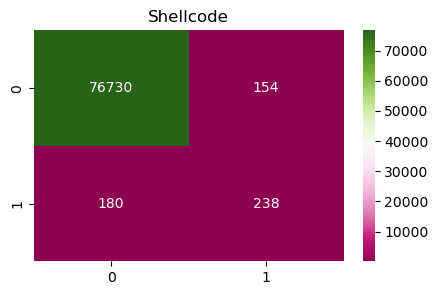

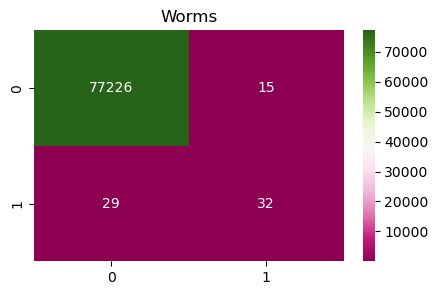

In [52]:
from sklearn.metrics import multilabel_confusion_matrix

# Calculate the multilabel confusion matrix for the test labels and predicted labels
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Iterate over each confusion matrix and the corresponding attack category
for i, j in zip(mcm, df['attack_cat'].value_counts().index):
    plt.subplots(figsize=(5, 3))
    
    # Plot the confusion matrix as a heatmap
    sns.heatmap(i, annot=True, fmt='d', cmap="PiYG")
    plt.title(j)


# Detailed explanation of the code is included in the methodology section

# Thank you